# Introduction
In this project we are going to analyze 'Brain tumor dataset', a T1 weighted MRI dataset from figshare,
<br>
apply preprocessing functions and create classification model based on Convolutional neural network that predicts brain tumor type.
#### This project inludes:
- Image data analysis
- Preprocessing data
- Creating neural network model
<br>

Highly reccomended to read the **data-description.txt** file to understand data organization.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import cv2 as cv
import os
import h5py
from PIL import Image
from skimage import exposure

# I Data preview
#### Step 1 - Image extraction
We're going to convert .mat files to .jpg files using h2py, PIL and skimage libraries.
<br><br>
Preprocessing images:
1) Exposure
2) Contrast stretching
3) Value scaling

In [2]:
tf.random.set_seed(0)
np.random.seed(0)
mat_path = 'D:\\data-science\\brain-tumor-data\\mat'
data_path = 'D:\\data-science\\brain-tumor-data\\images'
matrices = os.listdir(mat_path)

label_names = {1: 'meningioma',
               2: 'glioma',
               3: 'pituitary'}

In [ ]:
for i, mat in enumerate(matrices):
    with h5py.File(f"{mat_path}\\{mat}", 'r') as file:
        image = file['cjdata']['image']
        label = int(file['cjdata']['label'][0])

        # taking off 'near black' values to reduce background noise
        image = np.array(image) / np.max(image)
        image *= 255
        image[image <= 50] = 0
        
        # increase exposure
        image = exposure.equalize_hist(image)
        image *= 255
        
        # contrast streching
        image = (image - (image.min())) / (image.max() - (image.min()))
        image *= 255
        
        # color quantization
        image //= 100
        image *= 100
        
        # threshold / questionable, no satisfying results noticed
        # threshold = 100
        # image[image <= threshold] = 0
        # image[image > threshold] = 255
        
        image = np.array(image).astype(np.uint8)
        img_values = Image.fromarray(image)

        file_name = label_names[label] + f"_{i}.png"
        img_values.save(data_path + '\\' + label_names[label] + '\\' + file_name)
    # print(f"{(i + 1) / 3064 * 100} %")

In [ ]:
def preprocess_images(image):
    image = np.array(image) / np.max(image)
    image *= 255
    image[image <= 50] = 0
    
    # increase exposure
    image = exposure.equalize_hist(image)
    image *= 255
    
    # contrast streching
    image = (image - (image.min())) / (image.max() - (image.min()))
    image *= 255
    
    # color quantization
    image //= 100
    image *= 100
    
    return image

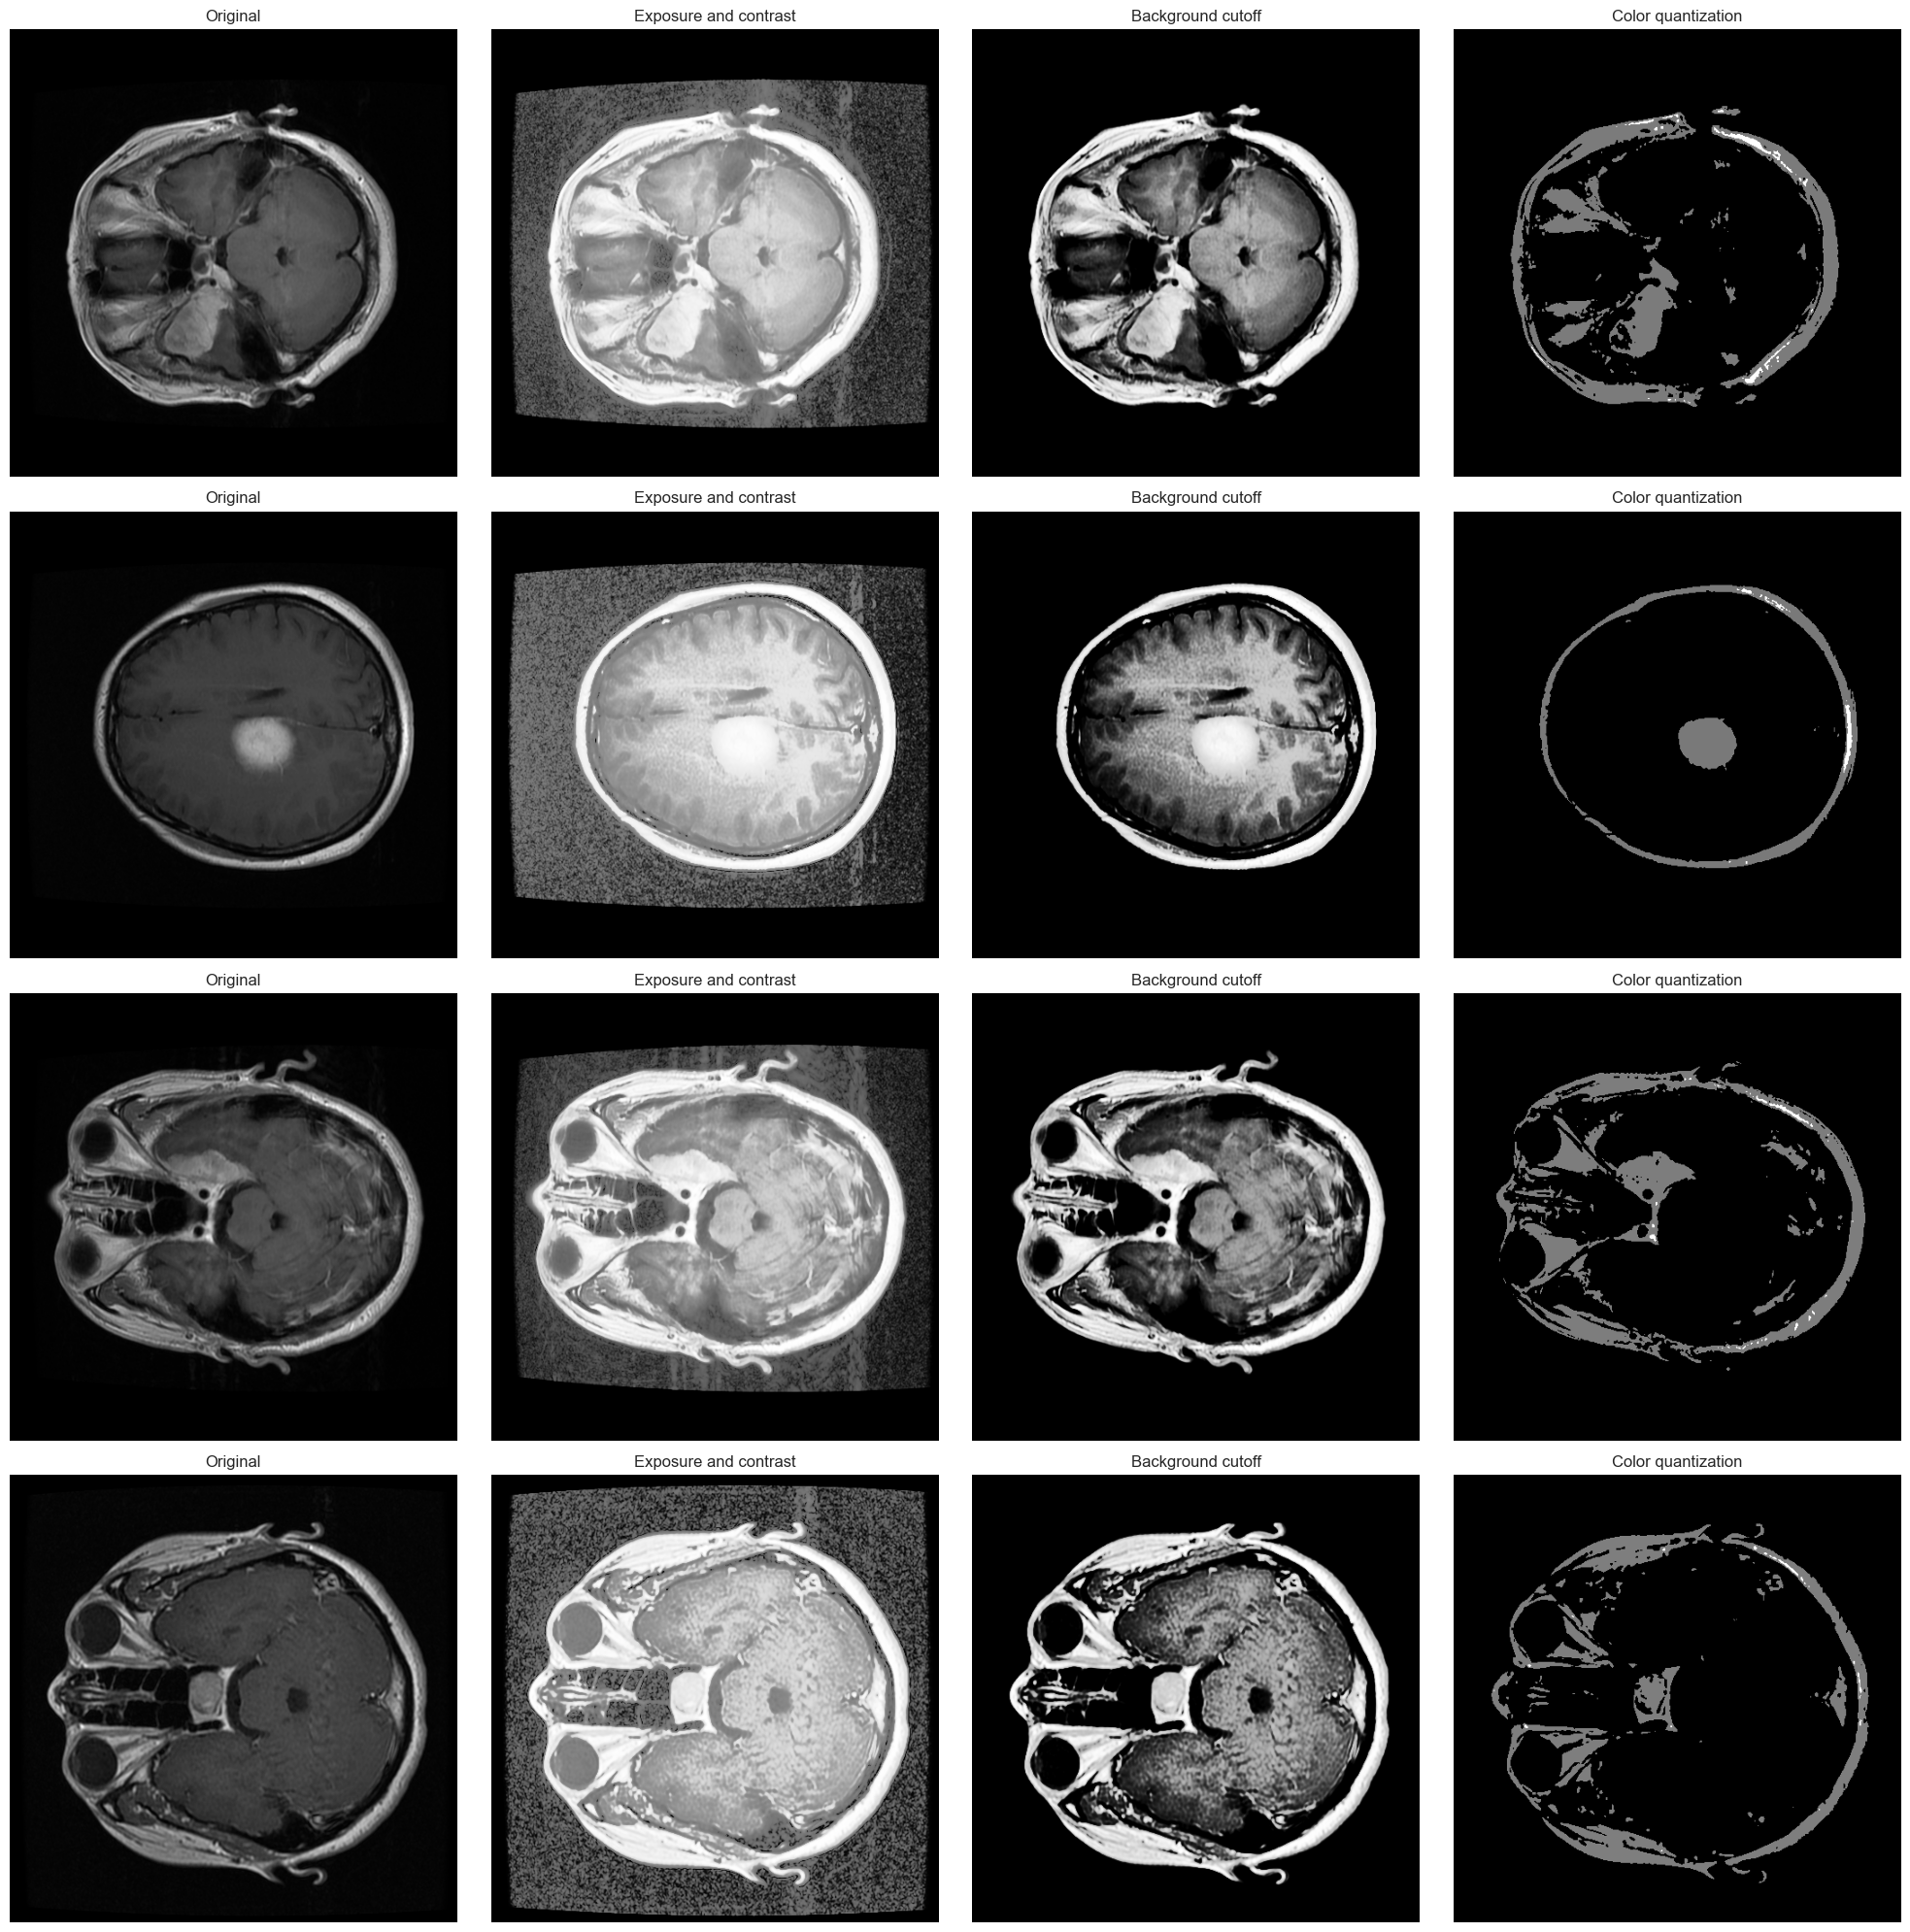

In [6]:
test_path = 'D:\\data-science\\brain-tumor-data\\test'
test_files = os.listdir(test_path)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))

for i, file in enumerate(test_files):
    img = Image.open(test_path + '\\' + file)
    y, x = [int(x[0]) for x in file.split('_')[1:]]
    
    axes[y, x].imshow(img, cmap='grey', vmin=0, vmax=255)
    axes[y, x].set_axis_off()
    axes[y, 0].set_title('Original')
    axes[y, 1].set_title('Exposure and contrast')
    axes[y, 2].set_title('Background cutoff')
    axes[y, 3].set_title('Color quantization')

plt.tight_layout()

In [13]:
data = tf.keras.utils.image_dataset_from_directory(data_path, batch_size=8, color_mode='grayscale', image_size=(256, 256))
print(f"Labels: {label_names}\n")

Found 3064 files belonging to 3 classes.
Labels: {1: 'meningioma', 2: 'glioma', 3: 'pituitary'}



In [14]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

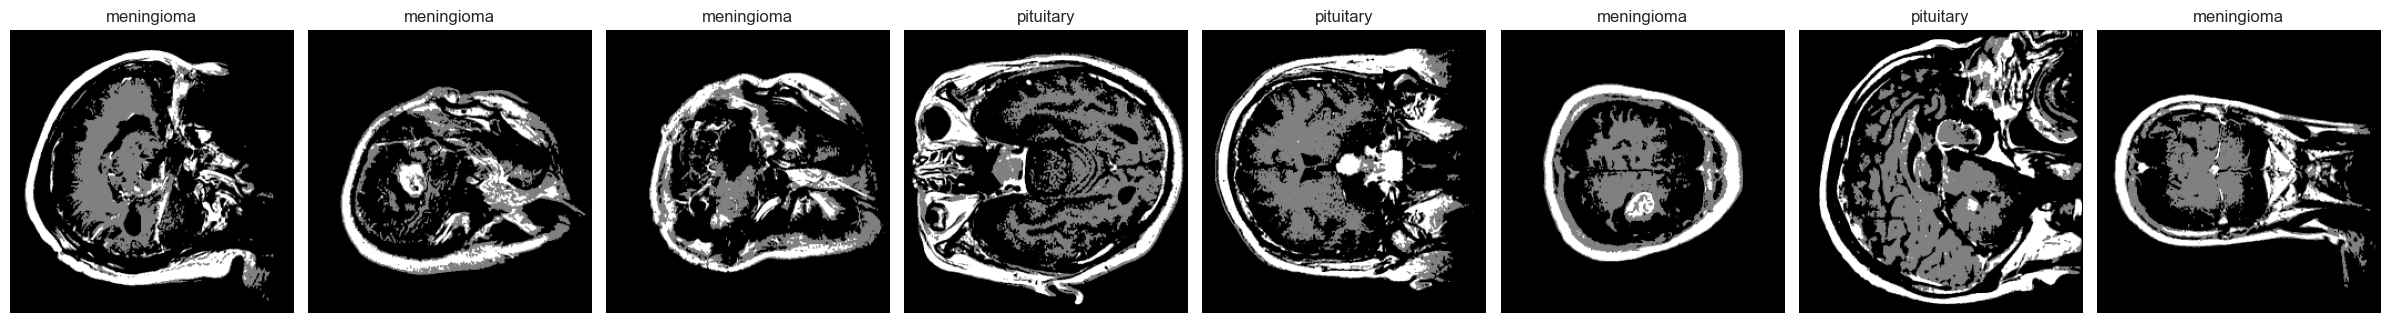

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(24, 6))
for i, img in enumerate(batch[0][:8]):
    class_name = label_names[batch[1][i]+1]
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(class_name)
    axes[i].set_axis_off()

plt.tight_layout()
plt.show()

Our dataset contains 512px x 512px images and each pixel has 3 channels so basically each image contains **786 432** values,
<br>
by using *color_mode = 'grayscale'* we reduce it to **262 144**. Also keras resized our files to size of 256px x 256px so we end up with **65 536** values per image.
<br><br>
I tested downsampling by removing random files from glioma and pituitary folders. However it didn't help at all, it even dropped accuracy by almost 10%,
<br>
apparently *glioma* class needs more support, because when we remove the data, accuracy on this class get significantly worse. 
<br>
**Class weights** on the other hand increased the final results by 3% (+10% for meningioma).

meningioma: 708
    glioma: 1426
 pituitary: 930


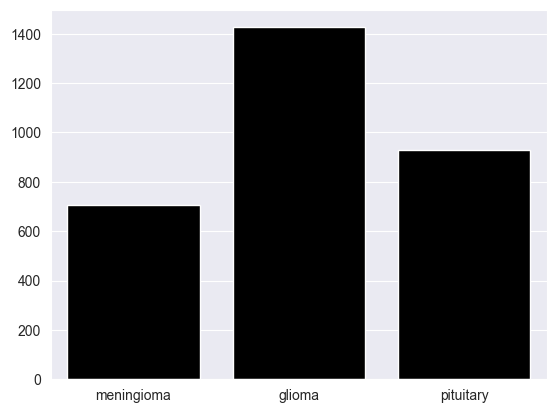

In [17]:
files_per_label = lambda folder: os.listdir(data_path + '\\' + folder)

# generate dictionary with lengths for each label
labels_len = {label: len(files_per_label(label)) for i, label in label_names.items()}

sb.barplot(data=labels_len, x=label_names.values(), y=labels_len.values(), color='Black')

for i, label in label_names.items():
    print(f"{label:>10}: {len(os.listdir(f"{data_path}\\{label}"))}")
    
plt.show()

# II Feature scaling
Scaling our values from range (0, 200) to (0, 1) will help our optimization algorithm (Adam).
<br>
Usually when we work with Images the max value is 255. However color quantization transformed 255 to 200.

In [18]:
print(batch[0].min(), batch[0].max(), sep='\n')

0.0
200.0


In [19]:
data = data.map(lambda x, y: (x/200, y))

In [20]:
iterator = data.as_numpy_iterator()
batch = iterator.next()

min_value = iterator.next()[0].min()
max_value = iterator.next()[0].max()

print(min_value, max_value, sep='\n')

0.0
1.0


Checking black/white balance in images. For selecting reference point on scale I used harmonic mean because it favortise lower values.
<br>
Every point on the plot is a single image, we can see that most of images hang around ratio of 0.59

          Mean: 0.5951886177062988
 Harmonic mean: 0.5944424867630005


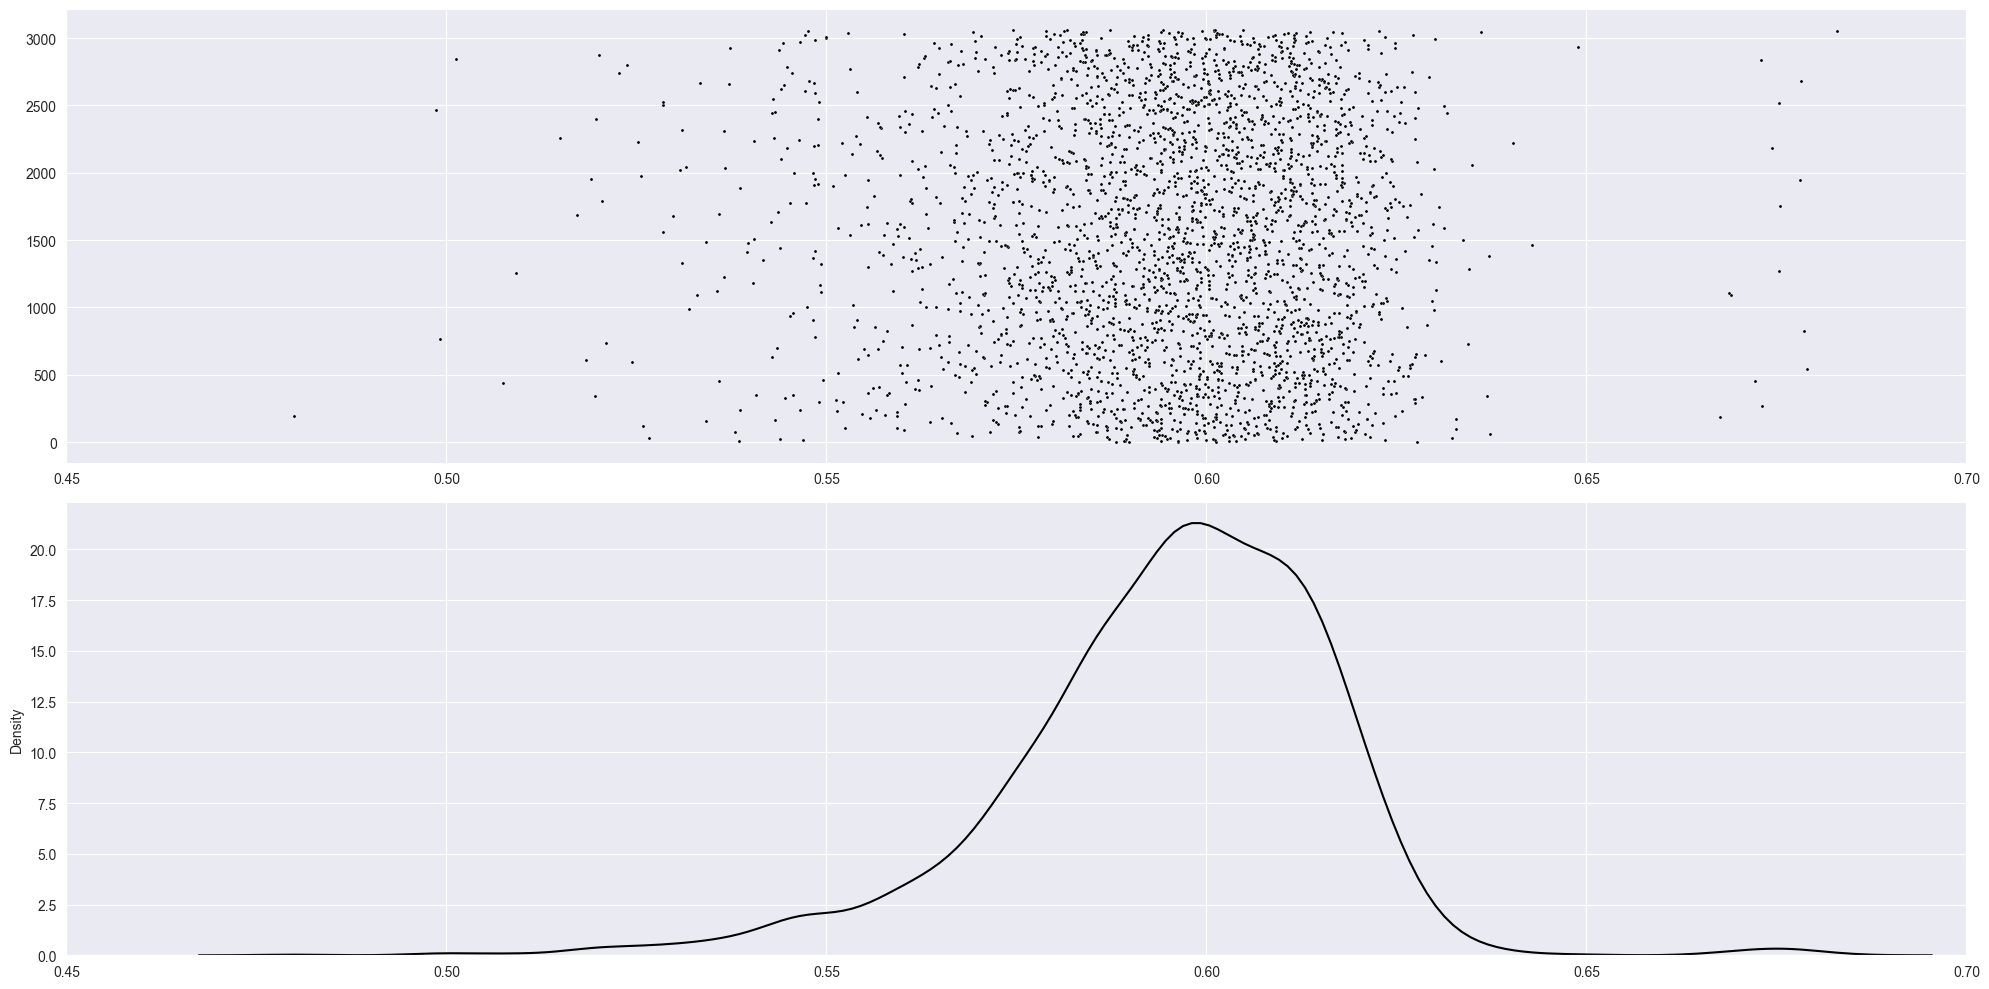

In [22]:
from scipy.stats.mstats import hmean

all_images = []
for images, label in data:
    all_images.append(images.numpy())

all_images = np.concatenate(all_images, axis=0)
# skipping value 0 because it's background and it will lower our mean
all_means = [x[x != 0].mean() for x in all_images]

print(f'{'Mean':>14}: {np.mean(all_means)}\n'
      f'{'Harmonic mean':>14}: {hmean(all_means)}')

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
sb.scatterplot(y=[x for x in range(len(all_means))], x=all_means, color='black', s=5, ax=axes[0])
sb.kdeplot(x=all_means, color='black', ax=axes[1])

axes[0].set_xlim([0.45, 0.7])
axes[1].set_xlim([0.45, 0.7])
plt.tight_layout()

# III Creating CNN Model
- In short: our model base on convolutional layers, where layers contain filter that convolve with input matrix (image) resulting filtered output.
<br>
- As input shape we apply values that corresponds to:
    - width = 256
    - height = 256
    - channel = 1 (we use grayscaled images).
<br>
- __*ReLU*__ activation function cleans our output from all unecesary negative values, replacing them with zeros that came from filter multiplication.
<br>
- Since our dataset contain 3 classes I applied __*softmax*__ activation to the last step.

In [23]:
train_batch_size = round(len(data) * 0.7)
val_batch_size = round(len(data) * 0.2)
test_batch_size = round(len(data) * 0.1)

len(data) == train_batch_size + val_batch_size + test_batch_size

True

In [24]:
train = data.take(train_batch_size)
val = data.skip(train_batch_size).take(val_batch_size)
test = data.skip(train_batch_size + val_batch_size).take(test_batch_size)

print(
    f"train: {len(train)} batches\nval: {len(val)} batches\ntest: {len(test)} batches"
)

train: 268 batches
val: 77 batches
test: 38 batches


Technically we supposed to to assign weights to integer values because later on we'll use loss='sparse_categorical_crossentropy' that is prepared for said value type.
<br><br>
Formula for class weight:
<br>
*class weight = dataset length / (class length * amount of classes in dataset)*

In [26]:
class_weights = dict()

for i, label in label_names.items():
    class_weights[i] = len(train) / labels_len[label] * len(label_names)

print(class_weights)

{1: 1.1355932203389831, 2: 0.5638148667601683, 3: 0.864516129032258}


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.optimizers import Adam, SGD

In [28]:
def create_model(num_filters = 16, kernel_size = 3, learning_rate = 0, regulate = 0):
    
    model = Sequential()
    
    model.add(Input(shape=(256, 256, 1)))
    
    model.add(Conv2D(num_filters, (kernel_size, kernel_size), 1, activation='relu'))
    model.add(MaxPooling2D())
    
    model.add(Conv2D(num_filters*2, (kernel_size, kernel_size), 1, activation='relu'))
    model.add(MaxPooling2D())
    
    model.add(Conv2D(num_filters, (kernel_size, kernel_size), 1, activation='relu'))
    model.add(MaxPooling2D())
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.7))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [29]:
model = create_model(learning_rate=0.0001)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,851 (14.10 MB)

 Trainable params: 3,696,851 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
n_epochs = 20
hist = model.fit(train, epochs=n_epochs, validation_data=val, class_weight=class_weights)

Epoch 1/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 23s 78ms/step - accuracy: 0.5546 - loss: 0.8020 - val_accuracy: 0.7240 - val_loss: 0.6456
Epoch 2/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.7182 - loss: 0.5906 - val_accuracy: 0.8036 - val_loss: 0.4930
Epoch 3/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.7980 - loss: 0.4664 - val_accuracy: 0.8442 - val_loss: 0.3946
Epoch 4/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.8479 - loss: 0.3547 - val_accuracy: 0.8880 - val_loss: 0.3379
Epoch 5/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - accuracy: 0.8882 - loss: 0.2857 - val_accuracy: 0.8750 - val_loss: 0.3169
Epoch 6/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - accuracy: 0.8907 - loss: 0.2639 - val_accuracy: 0.8653 - val_loss: 0.3251
Epoch 7/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.9206 - loss: 0.1917 - val_accuracy: 0.9010 - val_loss: 0.2619
Epoch 8/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - accuracy: 0.9286 - loss: 0.1923 - 

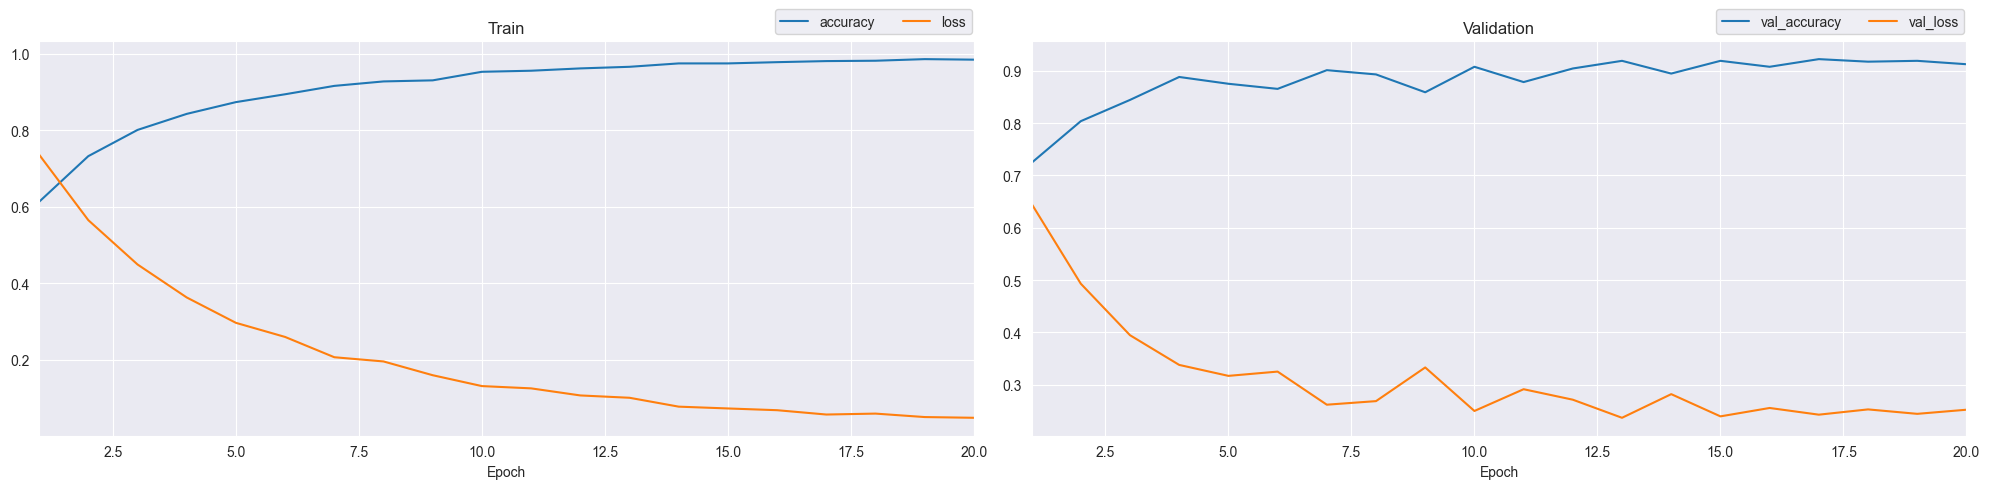

In [33]:
acc_labels = list(hist.history.keys())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
for i in range(4):
    fig = sb.lineplot(y=hist.history[acc_labels[i]], x=[x for x in range(1, n_epochs+1, 1)], label=acc_labels[i], ax=axes[i//2])
    axes[i//2].legend(loc='lower right', bbox_to_anchor=(1.005, 1), ncol=2)

axes[0].set_title('Train')
axes[0].set_xlabel('Epoch')
axes[0].set_xlim([1, n_epochs])

axes[1].set_title('Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_xlim([1, n_epochs])

plt.tight_layout()

Training process looks very promising, however we have to test our model for final results.

In [34]:
y_true = []
y_pred = []

for batch_images, batch_labels in test:
    y_true_batch = batch_labels
    y_pred_batch = np.argmax(model.predict(batch_images, verbose=0), axis=1)

    y_true.extend(y_true_batch)
    y_pred.extend(y_pred_batch)

              precision    recall  f1-score   support

  meningioma       0.93      0.93      0.93       138
      glioma       0.88      0.86      0.87        71
   pituitary       0.97      0.99      0.98        95

    accuracy                           0.93       304
   macro avg       0.93      0.93      0.93       304
weighted avg       0.93      0.93      0.93       304



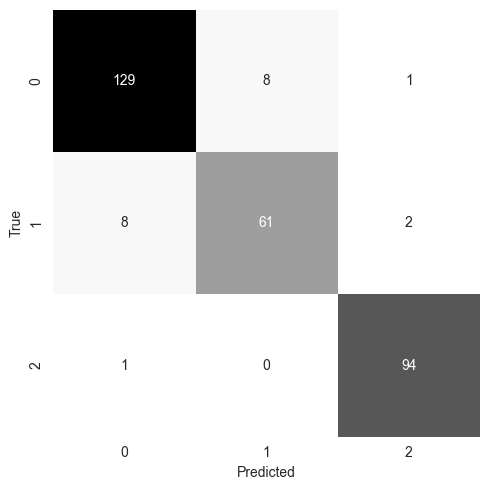

In [35]:
from sklearn.metrics import classification_report, confusion_matrix

report = classification_report(y_true, y_pred, target_names=label_names.values())
print(report)

cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
fig = plt.figure(figsize=(5, 5))
fig = sb.heatmap(cm, annot=True, fmt='d', cbar=False, cmap='Greys')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()

# IV Conclusion
After trying several regularizers like l1, l2, l1_l2, I finally decided to use Adam optimizer instead.